In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.data import AUTOTUNE
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print(f"Using TensorFlow {tf.__version__}!")

Using TensorFlow 2.7.0!


In [2]:
BATCH_SIZE = 128
INPUT_SHAPE = (32, 32, 3)

## Data pipeline

We will first create our x and y slices, and then pass them to a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset): by using this approach instead of straight using [`tf.data.Dataset.list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files), it allows us to map easily the filenames to their classes by avoiding string Tensors.

### **1. Create the `tf.data.Dataset` instance**

#### Create the x and y slices

In [3]:
files = list(Path("data/train").glob("*.jpg"))

# Create the x slice from the absolute file paths
x = list(map(str, files))

# Read the classes
classes = pd.read_csv("data/train.csv", index_col="id")
# Convert the DataFrame to a Series
classes = classes["has_cactus"]

# Make the y class list by matching the filenames to their classes
y = [classes[file.name] for file in files]

#### Use the slices to create the Dataset

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x, y))

### **2. Load the images (read + decode)**

In [5]:
def load_img(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    return img, label

In [6]:
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE)

### **3. Split the dataset**

So far we only loaded one dataset: the training one. Since this is the only one we have, we are going to reduce it in order to create additional validation and test datasets.

In [7]:
def split_dataset(ds, new_ds_size):
    new_ds = ds.take(new_ds_size)
    ds = ds.skip(new_ds_size)
    return ds, new_ds

In [8]:
train_size = len(train_ds)
val_size = int(train_size * .1)
test_size = int(train_size * .1)
print(f"{train_size} elements in the training set: taking {val_size} elements for validation and {test_size} for testing!")

train_ds, val_ds = split_dataset(train_ds, val_size)
train_ds, test_ds = split_dataset(train_ds, test_size)
print(f"Results: {len(train_ds)=}, {len(val_ds)=} and {len(test_ds)=}")

17500 elements in the training set: taking 1750 elements for validation and 1750 for testing!
Results: len(train_ds)=14000, len(val_ds)=1750 and len(test_ds)=1750


### **4. Cache, shuffle and batch the datasets**

In [9]:
def prepare(dataset, cache=True):
    if cache:
        dataset = dataset.cache()
    
    return dataset \
        .shuffle(buffer_size=len(dataset)) \
        .batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)

In [10]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds, cache=False)

### **5. Preprocessing**

See [https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method)

In [11]:
preprocessing = Sequential([
    layers.Resizing(width=INPUT_SHAPE[0], height=INPUT_SHAPE[1]),
    layers.Rescaling(1. / 255)
])

In [12]:
def apply_preprocess(dataset):
    return dataset.map(
        lambda x, y: (preprocessing(x), y),
        num_parallel_calls=AUTOTUNE
    )

In [13]:
train_ds = apply_preprocess(train_ds)
val_ds = apply_preprocess(val_ds)

### **6. Prefetch some elements**

In [14]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Visualize some images

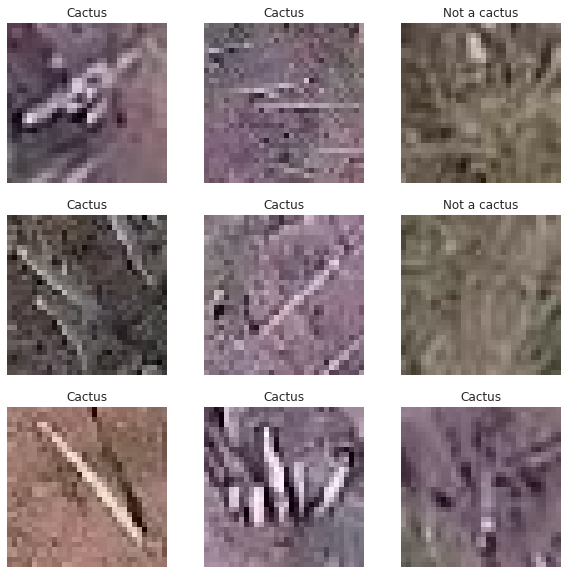

In [15]:
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(train_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy())
    plt.title("Cactus" if label else "Not a cactus")
    plt.axis("off")

## Create the model

In [16]:
model = Sequential([
    layers.Conv2D(16, 3, activation="relu", padding="same", input_shape=INPUT_SHAPE),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.Dropout(0.2),
    layers.Conv2D(64, 5, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        51264     
                                                      

**About the `from_logits` parameter**: `from_logits=True` means that the input value is in $[-inf, inf]$ and `from_logits=False` means that it is in $[0., 1.]$.

In the model we defined just above, the last layer output is limited to $[0., 1.]$ since we are using **sigmoid** as its activation function, so we must use `from_logits=False`.

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

## Training callbacks

In [18]:
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.15, # new_lr = lr * factor
    patience=5,
    min_lr=1e-5
)

In [19]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6
)

## Train it!

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        reduce_lr_on_plateau,
        early_stopping
    ]
)

Epoch 1/50
110/110 [==============================] - 5s 26ms/step - loss: 0.5860 - accuracy: 0.9256 - val_loss: 2.1496 - val_accuracy: 0.2651 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 2s 22ms/step - loss: 0.0553 - accuracy: 0.9811 - val_loss: 2.9698 - val_accuracy: 0.2651 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 3s 23ms/step - loss: 0.0301 - accuracy: 0.9889 - val_loss: 1.4345 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 3s 24ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 2.2939 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 3s 23ms/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.1595 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 3s 23ms/step - loss: 0.0118 - accuracy: 0.9957 - val_loss: 0.1609 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - 3s 23ms/st

## Results

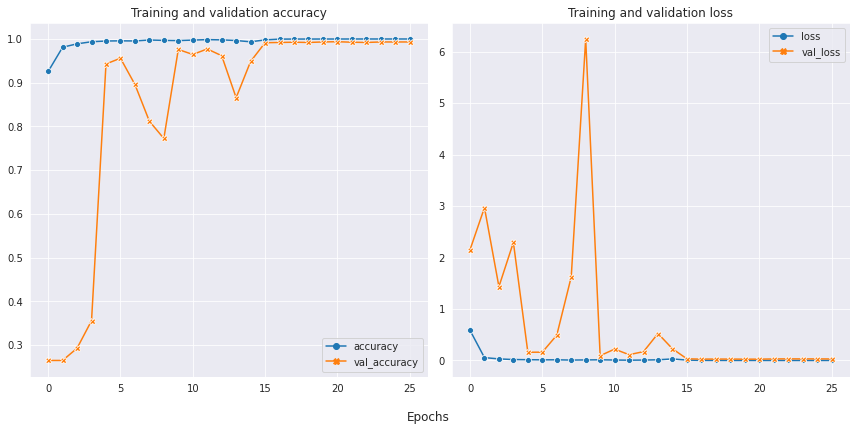

In [21]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(
    data={ key: history.history[key] for key in ["accuracy", "val_accuracy"] },
    dashes=False, markers=True, ax=axs[0]
).set_title("Training and validation accuracy")
sns.lineplot(
    data={ key: history.history[key] for key in ["loss", "val_loss"] },
    dashes=False, markers=True, ax=axs[1]
).set_title("Training and validation loss")

f.supxlabel("Epochs")
f.tight_layout()

In [22]:
model.evaluate(test_ds)

14/14 [==============================] - 0s 6ms/step - loss: 418.3787 - accuracy: 0.8274


[418.37872314453125, 0.8274285793304443]